## 3. Load data in csv format from the disk 
Since it takes some time to parse the excel files, you can speed up by loading the data in the csv format from the local disk.  

In [3]:
data = pd.read_csv('../data/data.csv')


### Add indicator column on whether the transnation is cancelled or not

In [38]:
def get_cancel_status(invoice_no):
    if 'c' in str(invoice_no).lower():
        return 1
    else:
        return 0
    
data['is_cancelled'] = [get_cancel_status(invoice_no) for invoice_no in data['InvoiceNo']]

In [4]:
unique_stock_code = list(set(data.StockCode))
mapping_idx2stock_code = dict(enumerate(unique_stock_code))
mapping_stock_code2idx = {v: k for k, v in mapping_idx2stock_code.items()}

In [5]:
unique_invoice_number = list(set(data.InvoiceNo))
mapping_idx2invoice_number = dict(enumerate(unique_invoice_number))
mapping_invoice_number2idx = {v: k for k, v in mapping_idx2invoice_number.items()}

In [6]:
mapping_stock_code2description = dict(zip(data.StockCode,data.Description))



#### 2. group stock code according to the invoice number. We assume each purchase has its own invoice number.

In [7]:
purchases = data[["InvoiceNo","StockCode"]].groupby("InvoiceNo").agg({'StockCode':lambda x: list(x)})

In [8]:
# map StockCode to their index, return array with invoice number, and list of StockCodeIndex
vals = purchases.StockCode.apply(lambda purchase: list(map(lambda stock_code: mapping_stock_code2idx.get(stock_code), purchase))).reset_index().values
# construct a tuple list of the form (invoice number index, stock_code_index, 1) 
invoice_stock_one = [(mapping_invoice_number2idx.get(row[0]), word, 1) for row in vals for word in row[1]]

In [183]:
#invoice_stock_one = [(mapping_invoice_number2idx.get(i),mapping_stock_code2idx.get(s) , 1) for (i,s) in zip(data.InvoiceNo,data.StockCode)]

In [9]:
# Build sparse matrix
import numpy as np
from scipy.sparse import coo_matrix,triu

rows, cols, val = map(np.array, zip(*invoice_stock_one))
invoice_stock_matrix = coo_matrix((val, (rows, cols)))

In [10]:
data_dropna = data.dropna()

In [11]:
unique_customer_id = set([int(id) for id in list(data_dropna.CustomerID)])

In [12]:
mapping_customer_id2idx = {k: v for k, v in zip(unique_customer_id,range(len(unique_customer_id)))}
mapping_idx2customer_id = {v: k for k, v in zip(unique_customer_id,range(len(unique_customer_id)))}

In [13]:
customer_stock_one = [((mapping_customer_id2idx.get(c),mapping_stock_code2idx.get(s)) , 1) for (c,s) in zip(data_dropna.CustomerID,data_dropna.StockCode)]

In [14]:
customer_stock_count = {}
for ((customer,stock),val) in customer_stock_one:
    if (customer,stock) not in customer_stock_count.keys():
        customer_stock_count[(customer,stock)]=val
    else:
        customer_stock_count[(customer,stock)]+=val

In [15]:
customer_stock_count = list(customer_stock_count.items())

In [16]:
# Build sparse matrix
import numpy as np
from scipy.sparse import coo_matrix

customer_stock, val= zip(*customer_stock_count)
rows, cols  = map(np.array, zip(*customer_stock))
val = np.array(val)
customer_stock_matrix = coo_matrix((val, (rows, cols)))

## Q3.1: Create a predictive model to estimate the probability that an order is cancelled. Therefor validate and tune three models of your choice.

In [17]:
ism = invoice_stock_matrix.tocsr()
sim = ism.transpose()
ssm = sim*ism

In [18]:
csm = customer_stock_matrix.tocsr()
scm = csm.transpose()

In [19]:
ssm

<4070x4070 sparse matrix of type '<class 'numpy.int64'>'
	with 7507222 stored elements in Compressed Sparse Column format>

In [20]:
csm

<4372x4070 sparse matrix of type '<class 'numpy.int64'>'
	with 267615 stored elements in Compressed Sparse Row format>

#### construct stock code to country coocurance matrix

In [21]:
unique_countries = set(list(data.Country))

In [22]:
mapping_country2idx = {k: v for k, v in zip(unique_countries,range(len(unique_countries)))}
mapping_idx2country = {v: k for k, v in zip(unique_countries,range(len(unique_countries)))}

In [23]:
country_stock_one = [((mapping_country2idx.get(c),mapping_stock_code2idx.get(s)) , 1) for (c,s) in zip(data.Country,data.StockCode)]

In [24]:
country_stock_count = {}
for ((country,stock),val) in country_stock_one:
    if (country,stock) not in country_stock_count.keys():
        country_stock_count[(country,stock)]=val
    else:
        country_stock_count[(country,stock)]+=val

In [25]:
country_stock_count = list(country_stock_count.items())

In [27]:
# Build sparse matrix
import numpy as np
from scipy.sparse import coo_matrix


country_stock, val= zip(*country_stock_count)
rows, cols  = map(np.array, zip(*country_stock))
val = np.array(val)
country_stock_matrix = coo_matrix((val, (rows, cols)))

In [28]:
lsm = country_stock_matrix.tocsr()#location_2_stock_code
lsmt = lsm.transpose()

In [29]:
lsm

<38x4070 sparse matrix of type '<class 'numpy.int64'>'
	with 19839 stored elements in Compressed Sparse Row format>

#### construct embeddings: decentralized alternative least square algorithm

In [176]:
#mapping_idx2country
#mapping_idx2customer_id
#mapping_idx2stock_code
#lsm
#csm
#ssm

In [30]:
from scipy.sparse import bmat
co_oc = bmat([[ssm],[csm],[lsm]])

#### Matrix factorization

In [31]:
A = co_oc.todense()
A = np.log(A+1)
U, s, V = np.linalg.svd(co_oc.todense(), full_matrices=True)
print(U.shape, V.shape, s.shape)

(8480, 8480) (4070, 4070) (4070,)


#### create embedding of transaction

In [33]:
dim_keep = 1000
embedings_stock = U[:len(unique_stock_code),:dim_keep]
embedings_customer = U[len(unique_stock_code):(len(unique_stock_code)+len(unique_customer_id)),:dim_keep]
embedings_country = U[(len(unique_stock_code)+len(unique_customer_id)):,:dim_keep]

In [34]:
np.mean(embedings_country)

2.5652214469102313e-05

In [35]:
np.std(embedings_country)

0.006926213399818288

In [36]:
embedings_country.shape

(38, 1000)

In [39]:
data_sub = data[["StockCode","CustomerID","Country","Quantity","UnitPrice","is_cancelled"]]
data_sub_dropna = data_sub.dropna()

In [40]:
quantity_mean = np.mean(np.abs(data.Quantity))

In [41]:
quantity_std = np.std(np.abs(data.Quantity))

In [42]:
unit_price_mean = np.mean(np.abs(data.UnitPrice))

In [43]:
unit_price_std = np.std(np.abs(data.UnitPrice))

In [44]:
label = np.array(data_sub_dropna.is_cancelled)

In [45]:
num_trans = len(data_sub_dropna)
output = np.zeros((num_trans,3*dim_keep+2))
for i in range(num_trans):
    trans = data_sub_dropna.iloc[i]
    c,s,l = trans.CustomerID,trans.StockCode,trans.Country 
    
    c_idx = mapping_customer_id2idx.get(c)
    s_idx = mapping_stock_code2idx.get(s)
    l_idx = mapping_country2idx.get(l)
    
    output[i,:dim_keep] = embedings_customer[c_idx,:]
    output[i,dim_keep:(2*dim_keep)] = embedings_stock[s_idx,:]
    output[i,2*dim_keep:3*dim_keep] = embedings_country[l_idx,:]
    output[i,-2] = (np.abs(trans.Quantity)- quantity_mean)/(quantity_std*100)
    output[i,-1] = (trans.UnitPrice- unit_price_mean)/(unit_price_std*100)
    

In [46]:
np.save('../data/data1000',output)

In [47]:
np.save('../data/label',label)

### Modeling

In [6]:
import numpy as np
data_np = np.load('../data/data1000.npy')
label_np = np.load('../data/label.npy')

In [51]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_np, label_np, test_size=0.33, random_state=42)

In [52]:
X_train.shape

(272575, 3002)

In [53]:
y_test

array([[0],
       [0],
       [1],
       ...,
       [0],
       [0],
       [0]])

In [54]:
import tensorflow as tf

#### a. Logistic regression

In [55]:
import tensorflow as tf

input_dim = 3*dim_keep+2
# Parameters
learning_rate = 0.001
training_epochs = 50
batch_size = 100
display_step = 1

graph = tf.Graph()
with graph.as_default():
    # tf Graph Input
    x = tf.placeholder(tf.float32, [None, input_dim]) # mnist data image of shape 28*28=784
    y = tf.placeholder(tf.float32, [None,1]) # 0-9 digits recognition => 10 classes

    # Set model weights
    W = tf.get_variable("W", (input_dim,1),initializer=tf.random_normal_initializer())
    b = tf.get_variable("b", (1),initializer=tf.random_normal_initializer())

    # Construct model
    logits = tf.matmul(x, W) + b
    pred = tf.nn.sigmoid(logits) 

    # Minimize error using cross entropy
    cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits,labels=y))
    # Gradient Descent
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

    # Initialize the variables (i.e. assign their default value)
    init = tf.global_variables_initializer()

    # Start training
    with tf.Session() as sess:

        # Run the initializer
        sess.run(init)

        # Training cycle
        for epoch in range(training_epochs):
            avg_cost = 0.
            total_batch = int(X_train.shape[0]/batch_size)
            # Loop over all batches
            for i in range(total_batch):
                batch_idx = np.random.choice(X_train.shape[0], batch_size)

                batch_xs, batch_ys = X_train[batch_idx,],y_train[batch_idx]
                # Run optimization op (backprop) and cost op (to get loss value)
                _, c = sess.run([optimizer, cost], feed_dict={x: batch_xs,
                                                              y: batch_ys})
                # Compute average loss
                avg_cost += c / total_batch
            # Display logs per epoch step
            if (epoch+1) % display_step == 0:
                print("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(avg_cost))

        print("Optimization Finished!")

        # Test model
        #correct_prediction = tf.equal(pred>0.5, y)
        # Calculate accuracy
        #accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        y_score_lg = pred.eval({x: X_test, y: y_test})


Epoch: 0001 cost= 0.148858292
Epoch: 0002 cost= 0.114693212
Epoch: 0003 cost= 0.105459063
Epoch: 0004 cost= 0.103762440
Epoch: 0005 cost= 0.102787821
Epoch: 0006 cost= 0.098604206
Epoch: 0007 cost= 0.098610566
Epoch: 0008 cost= 0.098407367
Epoch: 0009 cost= 0.097411990
Epoch: 0010 cost= 0.096461518
Epoch: 0011 cost= 0.095178362
Epoch: 0012 cost= 0.096046431
Epoch: 0013 cost= 0.094861611
Epoch: 0014 cost= 0.096080654
Epoch: 0015 cost= 0.095344979
Epoch: 0016 cost= 0.094589378
Epoch: 0017 cost= 0.096734506
Epoch: 0018 cost= 0.095915187
Epoch: 0019 cost= 0.093863710
Epoch: 0020 cost= 0.093370872
Epoch: 0021 cost= 0.092865240
Epoch: 0022 cost= 0.093514522
Epoch: 0023 cost= 0.093563355
Epoch: 0024 cost= 0.092384431
Epoch: 0025 cost= 0.092766220
Epoch: 0026 cost= 0.093241651
Epoch: 0027 cost= 0.092796964
Epoch: 0028 cost= 0.092380359
Epoch: 0029 cost= 0.093548201
Epoch: 0030 cost= 0.092333674
Epoch: 0031 cost= 0.092722497
Epoch: 0032 cost= 0.092230846
Epoch: 0033 cost= 0.092662343
Epoch: 003

In [57]:
from sklearn.metrics import roc_auc_score,accuracy_score, precision_score,recall_score,roc_curve,auc,confusion_matrix

fpr_lg, tpr_lg, _ = roc_curve(y_test, y_score_lg)
roc_auc_lg = auc(fpr_lg, tpr_lg)
    
y_pred_lg = y_score_lg>0.5
print(accuracy_score(y_test, y_pred_lg))
print(precision_score(y_test, y_pred_lg))
print(recall_score(y_test, y_pred_lg))
print(roc_auc_score(y_test, y_score_lg))
print(confusion_matrix(y_test, y_pred_lg))

0.978533228060244
0.5681818181818182
0.00865650969529086
0.7601460058221383
[[131347     19]
 [  2863     25]]


### random guess

In [58]:
y_score_rand= np.random.rand(len(y_test),1)

In [59]:
from sklearn.metrics import roc_auc_score,accuracy_score, precision_score,recall_score,roc_curve,auc

fpr_rand, tpr_rand, _ = roc_curve(y_test, y_score_rand)
roc_auc_rand = auc(fpr_rand, tpr_rand)
    
y_pred_rand = y_score_rand>0.5
print(accuracy_score(y_test, y_pred_rand))
print(precision_score(y_test, y_pred_rand))
print(recall_score(y_test, y_pred_rand))
print(roc_auc_score(y_test, y_score_rand))
print(confusion_matrix(y_test, y_pred_rand))

0.5007820996022465
0.02190183683206107
0.5086565096952909
0.5022373894120772
[[65763 65603]
 [ 1419  1469]]


#### Neural Network

In [60]:
import tensorflow as tf

def NN(X_train,X_test,y_train,y_test,input_dim=input_dim):


    # Parameters
    learning_rate = 0.001
    training_epochs = 50
    batch_size = 100
    display_step = 1
    h1 = 10
    h2 = 10
    h3 = 10

    graph = tf.Graph()
    with graph.as_default():

        # tf Graph Input
        x = tf.placeholder(tf.float32, [None, input_dim]) # mnist data image of shape 28*28=784
        y = tf.placeholder(tf.float32, [None,1]) # 0-9 digits recognition => 10 classes

        # Set model weights
        W1 = tf.get_variable("W1", (input_dim,h1),initializer=tf.random_normal_initializer())
        b1 = tf.get_variable("b1", (h1),initializer=tf.random_normal_initializer())

        W2 = tf.get_variable("W2",(h1, h2),initializer=tf.random_normal_initializer())
        b2 = tf.get_variable("b2",(h2),initializer=tf.random_normal_initializer())

        W3 = tf.get_variable("W3",(h2, h3),initializer=tf.random_normal_initializer())
        b3 = tf.get_variable("b3", (h3),initializer=tf.random_normal_initializer())

        W4 = tf.get_variable("W4", (h1,1),initializer=tf.random_normal_initializer())
        b4 = tf.get_variable("b4", (1),initializer=tf.random_normal_initializer())


        # Construct model
        z1 = tf.matmul(x, W1) + b1
        z1 = tf.nn.selu(z1)

        z2 = tf.matmul(z1, W2) + b2
        z2 = tf.nn.selu(z2)

        z3 = tf.matmul(z2, W3) + b3
        z3 = tf.nn.selu(z3)

        logits = tf.matmul(z3, W4) + b4

        pred = tf.nn.sigmoid(logits) 

        # Minimize error using cross entropy
        cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits,labels=y))
        # Gradient Descent
        optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

        # Initialize the variables (i.e. assign their default value)
        init = tf.global_variables_initializer()

        # Start training
        with tf.Session() as sess:

            # Run the initializer
            sess.run(init)

            # Training cycle
            for epoch in range(training_epochs):
                avg_cost = 0.
                total_batch = int(X_train.shape[0]/batch_size)
                # Loop over all batches
                for i in range(total_batch):
                    batch_idx = np.random.choice(X_train.shape[0], batch_size)

                    batch_xs, batch_ys = X_train[batch_idx,],y_train[batch_idx]
                    # Run optimization op (backprop) and cost op (to get loss value)
                    _, c = sess.run([optimizer, cost], feed_dict={x: batch_xs,
                                                                  y: batch_ys})
                    # Compute average loss
                    avg_cost += c / total_batch
                # Display logs per epoch step
                if (epoch+1) % display_step == 0:
                    print("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(avg_cost))

            print("Optimization Finished!")

            # Test model
            #correct_prediction = tf.equal(pred>0.5, y)
            # Calculate accuracy
            #accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
            y_score_nn = pred.eval({x: X_test, y: y_test})
            return y_score_nn





In [61]:
y_score_nn = NN(X_train,X_test,y_train,y_test)

Epoch: 0001 cost= 0.278019356
Epoch: 0002 cost= 0.106744953
Epoch: 0003 cost= 0.104735814
Epoch: 0004 cost= 0.102814039
Epoch: 0005 cost= 0.103539167
Epoch: 0006 cost= 0.096967301
Epoch: 0007 cost= 0.098860018
Epoch: 0008 cost= 0.097441650
Epoch: 0009 cost= 0.095863295
Epoch: 0010 cost= 0.095607638
Epoch: 0011 cost= 0.094073719
Epoch: 0012 cost= 0.095175081
Epoch: 0013 cost= 0.093042231
Epoch: 0014 cost= 0.092064863
Epoch: 0015 cost= 0.092219292
Epoch: 0016 cost= 0.090562149
Epoch: 0017 cost= 0.089943069
Epoch: 0018 cost= 0.092757382
Epoch: 0019 cost= 0.089425818
Epoch: 0020 cost= 0.090369433
Epoch: 0021 cost= 0.087758886
Epoch: 0022 cost= 0.088267139
Epoch: 0023 cost= 0.088184999
Epoch: 0024 cost= 0.086648725
Epoch: 0025 cost= 0.086783539
Epoch: 0026 cost= 0.087449995
Epoch: 0027 cost= 0.086220574
Epoch: 0028 cost= 0.084796861
Epoch: 0029 cost= 0.084407797
Epoch: 0030 cost= 0.084483317
Epoch: 0031 cost= 0.086611131
Epoch: 0032 cost= 0.084346380
Epoch: 0033 cost= 0.086380358
Epoch: 003

In [62]:
def evaluate(y_score_nn):
    from sklearn.metrics import roc_auc_score,accuracy_score, precision_score,recall_score,roc_curve,auc,confusion_matrix

    fpr_nn, tpr_nn, _ = roc_curve(y_test, y_score_nn)
    roc_auc_nn = auc(fpr_nn, tpr_nn)

    y_pred_nn = y_score_nn>0.5
    print("accuracy: ",accuracy_score(y_test, y_pred_nn))
    print("precision: ",precision_score(y_test, y_pred_nn))
    print("recall: ", recall_score(y_test, y_pred_nn))
    print("roc: ", roc_auc_score(y_test, y_score_nn))
    print("confusion matrix: \n",confusion_matrix(y_test, y_pred_nn))

In [63]:
from sklearn.metrics import roc_auc_score,accuracy_score, precision_score,recall_score,roc_curve,auc,confusion_matrix

fpr_nn, tpr_nn, _ = roc_curve(y_test, y_score_nn)
roc_auc_nn = auc(fpr_nn, tpr_nn)

y_pred_nn = y_score_nn>0.5
print("accuracy: ",accuracy_score(y_test, y_pred_nn))
print("precision: ",precision_score(y_test, y_pred_nn))
print("recall: ", recall_score(y_test, y_pred_nn))
print("roc: ", roc_auc_score(y_test, y_score_nn))
print("confusion matrix: \n",confusion_matrix(y_test, y_pred_nn))

accuracy:  0.978145902542941
precision:  0.4094488188976378
recall:  0.036011080332409975
roc:  0.7615210113943142
confusion matrix: 
 [[131216    150]
 [  2784    104]]


### comparison between models performance

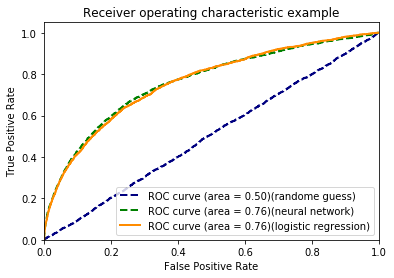

In [67]:
import matplotlib.pyplot as plt
plt.figure()
lw = 2
plt.plot(fpr_rand, tpr_rand, color='navy',linestyle='--',
         lw=lw, label='ROC curve (area = %0.2f)(randome guess)' % roc_auc_rand)
#plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.plot(fpr_nn, tpr_nn, color='green',linestyle='--',
         lw=lw, label='ROC curve (area = %0.2f)(neural network)' % roc_auc_nn)
#plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.plot(fpr_lg, tpr_lg, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)(logistic regression)' % roc_auc_lg)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

## Next step:
1. Replace the SVD with decentralized alternative least squre algorithm so that the embedding learning can be scaled up to even larger data set.
2. Parse time into local time given the courntry, and generate hour, working day, holiday, features. Finally, create embedding out of these features.
3. Incoperate the quantity and unit price into the cooccurance matrix construction.

#### 1. Isolate unit price

In [7]:
data_np_tmp = data_np[:,:-1]

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_np_tmp, label_np, test_size=0.33, random_state=42)
y_score_nn = NN(X_train, X_test, y_train, y_test,input_dim=3001)
evaluate(y_score_nn)

#### 2. Isolate quantity

In [ ]:
data_np_tmp = np.concatenate((data_np[:,:-2],data_np[:,-1].reshape(-1,1)),axis=1)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_np_tmp, label_np, test_size=0.33, random_state=42)
y_score_nn = NN(X_train, X_test, y_train, y_test,input_dim=3001)
evaluate(y_score_nn)

#### 3. Isolate customer

In [ ]:
data_np_tmp = data_np[:,1000:]

In [ ]:
data_np_tmp.shape

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_np_tmp, label_np, test_size=0.33, random_state=42)
y_score_nn = NN(X_train, X_test, y_train, y_test,input_dim=2002)
evaluate(y_score_nn)

#### 4. Isolate stock code

In [ ]:
data_np_tmp = np.concatenate((data_np[:,:1000],data_np[:,2000:]),axis=1)

In [ ]:
data_np_tmp.shape

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_np_tmp, label_np, test_size=0.33, random_state=42)
y_score_nn = NN(X_train, X_test, y_train, y_test,input_dim=2002)
evaluate(y_score_nn)

#### 5. Isolate country

In [ ]:
data_np_tmp = np.concatenate((data_np[:,:2000],data_np[:,3000:]),axis=1)

In [ ]:
data_np_tmp.shape

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_np_tmp, label_np, test_size=0.33, random_state=42)
y_score_nn = NN(X_train, X_test, y_train, y_test,input_dim=2002)
evaluate(y_score_nn)